In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
pip install pycountry

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=25a75aa93a51822fb88160f801454c6f2b3bd2d0338af9f4b4f2b4a21fa9bda3
  Stored in directory: /root/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry
Python interpreter will be restarted.


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Prep

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20230509104116/", (09 May 2023)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','news_cnt','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  #newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  #newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))

  newdf = newdf.withColumn('auth_seq', F.col('Au_Af').getItem('Authorseq'))
  newdf = newdf.withColumn('aff_seq', F.col('Au_Af').getItem('affiliation_seq'))
  newdf = newdf.withColumn("auth_pos", F.expr("array_position(auth_seq, cor_seq_first)"))

  newdf = newdf.withColumn("auth_pos", newdf["auth_pos"].cast(IntegerType()))  
  #newdf = newdf.filter(F.col('aff_seq').isNotNull())
  newdf = newdf.filter(F.col('auth_pos') != 0)
  newdf = newdf.withColumn("aff", F.element_at(newdf['aff_seq'], newdf['auth_pos']))
  newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  newdf = newdf.withColumn("cor_afid", F.col('aff_val').getItem('afid'))

  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("cor1_given_name", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  display(newdf.limit(10))

  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2

def get_gender(newdf):
  df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference)
  #non_null_count = newdf.where(F.col('Au1_id').isNotNull()).count()
  mergedf = df_gender.join(newdf, newdf.Au1_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender,newdf.doi,newdf.news_cnt,newdf.Au,newdf.Eid, newdf.year, newdf.publication_type,newdf.openaccess, newdf.issn, 
      newdf.num_au, newdf.Au1_id,newdf.Au2_id,newdf.Au_cor_id, newdf.srcid, newdf.subfield_article, newdf.subfield_journal, newdf.subfield_hybrid,newdf.correspondence,
      newdf.cor1_given_name, newdf.cor_afid)
  mergedf = mergedf.withColumnRenamed('Inferred_Probable_Gender', 'Au1_gender')

  mergedf2 = df_gender.join(mergedf, mergedf.Au2_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf.doi,mergedf.news_cnt,mergedf.Au,mergedf.Eid, mergedf.year, mergedf.publication_type,mergedf.openaccess, mergedf.issn, 
      mergedf.num_au, mergedf.Au1_id,mergedf.Au2_id,mergedf.Au_cor_id, mergedf.srcid, mergedf.subfield_article, mergedf.subfield_journal, mergedf.subfield_hybrid, mergedf.Au1_gender,mergedf.correspondence,mergedf.cor1_given_name,mergedf.cor_afid)
  mergedf2 = mergedf2.withColumnRenamed('Inferred_Probable_Gender', 'Au2_gender')

  #mergedf2 = mergedf2.withColumn('no_cor', F.size(mergedf2['Au_cor_id']))
  #display("len os final4 ", mergedf2.count(),"\n")

  mergedf2 = mergedf2.withColumn('cor_au1', first(mergedf2['Au_cor_id']))

  #display(final_data4.limit(20))

  mergedf3 = mergedf2.filter(F.col('cor_au1').isNotNull())
  display("no of not null cor au",mergedf3.count(),"\n")

  mergedf4 = df_gender.join(mergedf3, mergedf3.cor_au1 == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf3.doi,mergedf3.news_cnt,mergedf3.Au,mergedf3.Eid, mergedf3.year, mergedf3.publication_type,mergedf3.openaccess, mergedf3.issn, 
      mergedf3.num_au, mergedf3.Au1_id,mergedf3.Au2_id,mergedf3.Au_cor_id, mergedf3.srcid, mergedf3.subfield_article, mergedf3.subfield_journal, mergedf3.subfield_hybrid, mergedf3.Au1_gender,mergedf3.Au2_gender,mergedf3.cor_au1,mergedf3.correspondence,mergedf3.cor1_given_name, mergedf3.cor_afid)
  mergedf4 = mergedf4.withColumnRenamed('Inferred_Probable_Gender', 'cor_gender')

  return mergedf4

def merge_news_cnt(scop):
  scop = scop.filter(func.col('year') >= 2018)
  scop = scop.filter(func.col('year') <= 2022)
  df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_news_final.csv")
  display("# doi data from crossref and altmetric ",df1.count(),"\n")
  df = scop.join(df1, 'doi','inner')
  df = df.withColumn("news_cnt", df["news_cnt"].cast(IntegerType()))
  return df

from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
display("len of df_ani in english ",d2.count(),"\n")

with_news = merge_news_cnt(d2)
display("merged data len between crossref and scopus ",with_news.count(),"\n")

newdf = extract_publication_info(with_news)

df_class = get_smc_classification(newdf)
final_data = get_gender(df_class)
display(final_data.count(),"\n")
final_data2 = final_data.dropna(subset=["doi"])
display(final_data2.count(),"\n")

##extracting sci_val topic for each publication
df_top_eids = spark.read.format("parquet").load(basePath+tablename_top_topic_eid)

final_data3 = final_data2.join(df_top_eids,'Eid','inner')
#display(final_data3.count())
display(final_data3.limit(10))


import pyspark.sql.functions as F
import pyspark.sql.column as C

def find_sjr(met,yy,yr):

  ylst = F.tolist(yy)

  #index = ylst.index(yr)
  #sjr = m[index]
  return m


df_sources = spark.read.format("parquet").load(basePath+tablename_sources)

data = final_data3.join(df_sources,'srcid','inner').select(df_sources.metrics_calculations,df_sources.sourcetitle,df_sources.openaccess_status,final_data3.srcid,final_data3.doi,final_data3.news_cnt,final_data3.year,
final_data3.publication_type, final_data3.issn, final_data3.num_au,final_data3.Au1_id, final_data3.subfield_article,final_data3.subfield_journal, final_data3.Au1_gender,final_data3.TopicId, 
final_data3.cor_gender,final_data3.cor_au1,final_data3.correspondence, final_data3.cor1_given_name, final_data3.cor_afid)

display("len of merged data between src ", data.count(),"\n")

data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))

#data = data.withColumn('SJR', find_sjr(data['SJR_lst'],data['year_SJR'], data['year']))
data = data.withColumn("pos", F.expr("array_position(year_SJR, year)"))


data = data.withColumn("pos", data["pos"].cast(IntegerType()))  
data = data.withColumn("SJR", F.element_at(data['SJR_lst'], data['pos']))

data = data.withColumn('cor_af', first(data['correspondence']))
data = data.withColumn('cor_coun', F.col('cor_af').getItem('country'))



import pycountry
import pyspark.sql.functions as F

def convert_country_short_name(country_short_name):
  #country = pycountry.countries.get(alpha_2=country_short_name)
  if len(country_short_name) == 3:
    country = pycountry.countries.get(alpha_3=country_short_name)
  else:
    country = pycountry.countries.get(alpha_2=country_short_name)

  return country.name if country else None

@F.udf(returnType=F.StringType())
def my_udf(country_short_name):
  return convert_country_short_name(country_short_name)

data = data.filter(F.col('cor_coun').isNotNull())
data = data.withColumn("country_name", my_udf(data["cor_coun"]))
#un_full_coun = un_name.withColumn("country_name", my_udf(un_name["cor_coun"]))

df_ipr = spark.read.format("parquet").load(basePath+tablename_ipr)
data = data.join(df_ipr,[data.cor_afid == df_ipr.afid],'inner')
display(data.limit(10))

val_data = data.filter(func.col('cor_gender') != 'unknown')

#val_un = data.filter(func.col('cor_gender') == 'unknown')



display("len of data whose cor_gender is not unknown ",val_data.count(),"\n")

display(val_data.limit(5),"\n")


#val_un = data.filter(func.col('cor_gender') == 'unknown')
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
#un_full_coun = val_un.join(df_apr,val_un.cor_au1 == df_apr.auid,'inner')
un_full_coun = data.filter(func.col('cor_gender') == 'unknown')

display("len of unknown name ", un_full_coun.count(),"\n")
un_full_coun = un_full_coun.filter(F.col('cor1_given_name').isNotNull())
un_full_coun = un_full_coun.filter(F.col('country_name').isNotNull())
display("len of unknown name after dropping null country and given name ", un_full_coun.count(),"\n")
df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
#df_wos.printSchema()
#df_wos = df_wos.filter(func.col('country') == 'China')
newfile = un_full_coun.join(df_wos,[un_full_coun.cor1_given_name == df_wos.givenname,un_full_coun.country_name == df_wos.country],'inner')
display("len or merged gender with wos ", newfile.count(),"\n")


'len of df_ani '92977146'\n''len of df_ani in english '81101357'\n''# doi data from crossref and altmetric '9061001'\n''merged data len between crossref and scopus '6638549'\n'

doi,Eid,year,Au,Au_Af,Au_cors,publication_type,openaccess,issn,source,news_cnt,correspondence,Af,Au1,Au2,num_au,Au1_id,Au2_id,Au_cor_id,cor_seq,cor_seq_first,auth_seq,aff_seq,auth_pos,aff,aff_val,cor_afid,given_seq,cor1_given_name
10.1001/jama.2017.20952,85043226815,2018,"List(List(1, 56813936800, auth, false, BA, cdcdf30c4c72a5f61c8eb00141555a59d0aac514, Theodore T., Theodore T., Lee T.T., Lee T.T., T.T., T.T., null, null, null, Lee, Lee), List(2, 6506525459, auth, false, MD, JD, MPH, null, Aaron S., Aaron S., Kesselheim A.S., Kesselheim A.S., A.S., A.S., null, null, null, Kesselheim, Kesselheim), List(3, 6506387711, auth, false, JD, null, Amy, Amy, Kapczynski A., Kapczynski A., A., A., null, null, null, Kapczynski, Kapczynski))","List(List(1, 1, true), List(2, 2, true), List(3, 3, true))","List(List(1, 56813936800, null, false, BA, null, Theodore T., null, Lee T.T., null, T.T., null, null, null, null, Lee, null))",no,None,00987484,"List(null, null, usa, 06, 03, 6 March 2018, 2018, smcleod@itsa.ucsf.edu, email, null, null, null, List(15383598), null, List(00987484), American Medical Association, JAMA - Journal of the American Medical Association, JAMA, 85291, j, https://jamanetwork.com/journals/jama/articlepdf/2672841/jama_lee_2018_vp_170197.pdf)",41,"List(List(usa, null))","List(List(127 Wall St, New Haven, null, United States, List(60005455), List(Yale Law School, Yale University), 2, 06511, CT, usa, null, 60005455, 103317903), List(null, Boston, null, United States, List(60002746, 60016782), List(Program On Regulation, Therapeutics, and Law (PORTAL), Division of Pharmacoepidemiology and Pharmacoeconomics, Department of Medicine, Brigham and Women’s Hospital, Harvard Medical School), 7, null, MA, usa, null, 60002746, 118978541), List(null, New Haven, null, United States, List(60005455), List(Collaboration for Research Integrity and Transparency (CRIT), Yale Law School), 2, null, CT, usa, null, 60005455, 119725525))","List(1, 56813936800, auth, false, BA, cdcdf30c4c72a5f61c8eb00141555a59d0aac514, Theodore T., Theodore T., Lee T.T., Lee T.T., T.T., T.T., null, null, null, Lee, Lee)","List(3, 6506387711, auth, false, JD, null, Amy, Amy, Kapczynski A., Kapczynski A., A., A., null, null, null, Kapczynski, Kapczynski)",3,56813936800,6506387711,List(56813936800),List(1),1,"List(1, 2, 3)","List(1, 2, 3)",1,1,"List(127 Wall St, New Haven, null, United States, List(60005455), List(Yale Law School, Yale University), 2, 06511, CT, usa, null, 60005455, 103317903)",60005455,"List(Theodore T., Aaron S., Amy)",Theodore T.
10.1001/jama.2017.21752,85042047525,2018,"List(List(1, 57200639953, auth, false, null, 5466620b210ccb9fef349e079b265a00510239f1, Jennifer R., Jennifer R., Henneman J.R., Henneman J., J.R., J.R., null, null, null, Henneman, Henneman))","List(List(1, 1, true))","List(List(1, 57200639953, null, false, null, null, Jennifer R., null, Henneman J.R., null, J.R., null, null, null, null, Henneman, null))",ar,None,00987484,"List(null, null, usa, 13, 02, 13 February 2018, 2018, smcleod@itsa.ucsf.edu, email, null, null, null, List(15383598), null, List(00987484), American Medical Association, JAMA - Journal of the American Medical Association, JAMA, 85291, j, https://jamanetwork.com/journals/jama/currentissue)",0,"List(List(usa, null))","List(List(100 W Ave Pkwy, Denver, null, United States, List(101141036), List(Petrie Institute of Western American Art, Denver Art Museum), 2, 80204, CO, usa, null, 101141036, 106764742))","List(1, 57200639953, auth, false, null, 5466620b210ccb9fef349e079b265a00510239f1, Jennifer R., Jennifer R., Henneman J.R., Henneman J., J.R., J.R., null, null, null, Henneman, Henneman)","List(1, 57200639953, auth, false, null, 5466620b210ccb9fef349e079b265a00510239f1, Jennifer R., Jennifer R., Henneman J.R., Henneman J., J.R., J.R., null, null, null, Henneman, Henneman)",1,57200639953,57200639953,List(57200639953),List(1),1,List(1),List(1),1,1,"List(100 W Ave Pkwy, Denver, null, United States, List(101141036), Lis

'no of not null cor au'5959143'\n'5950657'\n'5950657'\n'

Eid,cor_gender,doi,news_cnt,Au,year,publication_type,openaccess,issn,num_au,Au1_id,Au2_id,Au_cor_id,srcid,subfield_article,subfield_journal,subfield_hybrid,Au1_gender,Au2_gender,cor_au1,correspondence,cor1_given_name,cor_afid,TopicId
84961226628,unknown,10.1016/j.resconrec.2016.03.007,0,"List(List(1, 55924882600, auth, false, null, 7df62066aefcbeac922958fe9a15aa149c77905d, Ye, Ye, Li Y., Li Y., Y., Y., null, null, null, Li, Li), List(2, 57184720700, auth, false, null, 822d32e4913890b657bc44eb7ea8b3c05cb11b23, Qing, Qing, He Q., He Q., Q., Q., null, null, null, He, He), List(3, 57072127000, auth, false, null, a4eb2b2aa959d3b99ac80146df5c2e71b0a845d1, Xiao, Xiao, Luo X., Luo X., X., X., null, 0000-0001-6122-2211, null, Luo, Luo), List(4, 57038892100, auth, false, null, 03de14adb487bda321f77861e013682b17df1d7a, Yiran, Yiran, Zhang Y., Zhang Y., Y., Y., null, null, null, Zhang, Zhang), List(5, 55752935000, auth, false, null, 825f36c32d8481f324a413e77e02ee994b93e8d2, Liang, Liang, Dong L., Dong L., L., L., null, null, null, Dong, Dong))",2018,ar,None,09213449,5,55924882600,55752935000,List(57072127000),26424,environmental sciences,environmental sciences,environmental sciences,unknown,unknown,57072127000,"List(List(chn, null))",Xiao,60073652,59694
84971656750,male,10.1016/j.jasrep.2016.05.052,0,"List(List(1, 7101995035, auth, false, null, null, Gunilla, Gunilla, Eriksson G., Eriksson G., G., G., null, 0000-0002-9926-6524, null, Eriksson, Eriksson), List(2, 15749241800, auth, false, null, null, Karin Margarita, Karin Margarita, Frei K.M., Frei K.M., K.M., K.M., null, null, null, Frei, Frei), List(3, 55318651600, auth, false, null, null, Rachel, Rachel, Howcroft R., Howcroft R., R., R., null, null, null, Howcroft, Howcroft), List(4, 57189522948, auth, false, null, null, Sara, Sara, Gummesson S., Gummesson S., S., S., null, null, null, Gummesson, Gummesson), List(5, 57189521040, auth, false, null, null, Fredrik, Fredrik, Molin F., Molin F., F., F., null, null, null, Molin, Molin), List(6, 7003643642, auth, false, null, null, Kerstin, Kerstin, Liden K., Lidén K., K., K., null, null, null, Lidén, Lidén), List(7, 7103231290, auth, false, null, null, Robert, Robert, Frei R., Frei R., R., R., null, null, null, Frei, Frei), List(8, 55318039900, auth, false, null, ec6b2f43c1c15e022a30a3dd58303b66d0e57706, Fredrik, Fredrik, Hallgren F., Hallgren F., F., F., null, null, null, Hallgren, Hallgren))",2018,ar,None,2352409X,8,7101995035,55318039900,List(55318039900),21100369721,archaeology,archaeology,archaeology,female,male,55318039900,"List(List(swe, null))",Fredrik,116739376,3394
84975129749,male,10.1016/j.ecss.2016.05.019,0,"List(List(1, 7102119738, auth, false, null, 94530784ea84f2275f8b6490e17285dc36405963, Myron A., Myron A., Peck M.A., Peck M.A., M.A., M.A., null, null, null, Peck, Peck), List(2, 6602439394, auth, false, null, null, Christos, Christos, Arvanitidis C., Arvanitidis C., C., C., null, null, null, Arvanitidis, Arvanitidis), List(3, 36156979600, auth, false, null, null, Momme, Momme, Butenschon M., Butenschön M., M., M., null, null, null, Butenschön, Butenschön), List(4, 57208816987, auth, false, null, null, Donata Melaku, Donata Melaku, Canu D.M., Canu D.M., D.M., D.M., null, null, null, Canu, Canu), List(5, 9737818000, auth, false, null, null, Eva, Eva, Chatzinikolaou E., Chatzinikolaou E., E., E., null, null, null, Chatzinikolaou, Chatzinikolaou), List(6, 6506416319, auth, false, null, null, Andrea, Andrea, Cucco A., Cucco A., A., A., null, null, null, Cucco, Cucco), List(7, 55901479500, auth, false, null, null, Paolo, Paolo, Domenici P., Domenici P., P., P., null, null, null, Domenici, Domenici), List(8, 24553992900, auth, false, null, null, Jose A., Jose A., Fernandes J.A., Fernandes J.A., J.A., J.A., null, null, null, Fernandes, Fernandes), List(9, 54385035400, auth, false, null, null, Loic, Loic, Gasche L., Gasche L., L., L., null, null, null, Gasche, Gasche), List(10, 25230018900, auth, false, null, null, Klaus B., Klaus B

'len of merged data between src '5859673'\n'

metrics_calculations sourcetitle openaccess_status srcid doi news_cnt year publication_type issn num_au Au1_id subfield_article subfield_journal Au1_gender TopicId cor_gender cor_au1 correspondence cor1_given_name cor_afid SJR_lst year_SJR pos SJR cor_af cor_coun country_name afid preferred_name sort_name address_part postal_code city state country country_tag name_variant org_domain org_type parent parent_preferred_name List(List(null, null, 2551.0, 1917.0, null, 334, 0.0, Complete, 1996, 6, 6), List(null, null, 2961.0, 2251.0, null, 315, 0.32, Complete, 1997, 4, 4), List(null, null, 3586.0, 2939.0, null, 372, 0.0, Complete, 1998, 8, 9), List(0.916, 1.131, 4105.0, 3224.0, null, 292, 0.0, Complete, 1999, 1, 2), List(0.952, 1.371, 4767.0, 3606.0, null, 529, 0.19, Complete, 2000, 6, 6), List(0.841, 1.245, 5906.0, 4336.0, null, 501, 0.2, Complete, 2001, 6, 6), List(1.099, 1.095, 6979.0, 5950.0, null, 315, 0.0, Complete, 2002, 2, 2), List(1.185, 1.377, 8833.0, 6943.0, null, 536, 0.19, Complete, 2003, 4, 4), List(1.327, 1.491, 10082.0, 8553.0, null, 440, 0.23, Complete, 2004, 4, 4), List(1.28, 1.842, 13860.0, 11251.0, null, 754, 0.27, Complete, 2005, 7, 9), List(1.359, 1.55, 16109.0, 13662.0, null, 723, 0.55, Complete, 2006, 9, 10), List(1.446, 1.575, 20376.0, 17030.0, null, 821, 1.46, Complete, 2007, 4, 6), List(1.448, 1.546, 22344.0, 18945.0, null, 838, 1.55, Complete, 2008, 4, 5), List(1.317, 1.524, 25564.0, 22136.0, null, 780, 1.28, Complete, 2009, 6, 6), List(1.434, 1.43, 28197.0, 24641.0, null, 776, 0.77, Complete, 2010, 3, 3), List(1.485, 1.727, 34325.0, 29998.0, List(List(19706, 6.0, 77, 3261, List(List(3105, List(90, 2), 98), List(2506, List(126, 5), 96), List(2505, List(233, 13), 94), List(2208, List(589, 35), 94), List(3104, List(383, 25), 93), List(2508, List(91, 7), 92), List(2504, List(183, 17), 90)))), 909, 1.1, Complete, 2011, 8, 8), List(1.412, 1.637, 36849.0, 32131.0, List(List(20977, 6.1, 76, 3451, List(List(3105, List(91, 2), 98), List(2506, List(127, 5), 96), List(3104, List(387, 24), 93), List(2505, List(234, 15), 93), List(2508, List(93, 7), 93), List(2208, List(615, 45), 92), List(2504, List(193, 17), 91)))), 1020, 1.27, Complete, 2012, 7, 10), List(1.261, 1.628, 42963.0, 36467.0, List(List(24104, 6.0, 77, 4034, List(List(3105, List(95, 2), 98), List(2506, List(136, 6), 95), List(3104, List(388, 27), 93), List(2505, List(240, 17), 93), List(2508, List(96, 8), 92), List(2208, List(631, 51), 91), List(2504, List(199, 19), 90)))), 1359, 1.32, Complete, 2013, 12, 12), List(1.229, 1.651, 49454.0, 42339.0, List(List(29686, 6.2, 81, 4781, List(List(3105, List(99, 2), 98), List(2506, List(137, 5), 96), List(2508, List(101, 7), 93), List(2505, List(249, 17), 93), List(3104, List(395, 28), 93), List(2208, List(651, 47), 92), List(2504, List(207, 18), 91)))), 1516, 0.99, Complete, 2014, 8, 10), List(1.225, 1.506, 55661.0, 48726.0, List(List(39508, 7.4, 85, 5332, List(List(3105, List(104, 1), 99), List(2506, List(141, 5), 96), List(2505, List(253, 13), 95), List(2508, List(105, 6), 94), List(2208, List(660, 37), 94), List(3104, List(401, 23), 94), List(2504, List(213, 16), 92)))), 1507, 1.13, Complete, 2015, 6, 6), List(1.343, 1.46, 63724.0, 55605.0, List(List(51317, 8.6, 88, 5954, List(List(3105, List(106, 1), 99), List(2506, List(145, 5), 96), List(2508, List(110, 5), 95), List(2505, List(253, 11), 95), List(3104, List(402, 20), 95), List(2208, List(654, 34), 94), List(2504, List(219, 17), 92)))), 1630, 1.1, Complete, 2016, 5, 6), List(1.406, 1.457, 72138.0, 62016.0, List(List(63159, 9.3, 88, 6814, List(List(3105, List(123, 1), 99), List(2506, List(152, 5), 97), List(2508, List(117, 5), 96), List(3104, List(395, 20), 95), List(2505, List(270, 14), 95), List(2208, List(666, 35), 94), List(2504, List(225, 17), 92)))), 2196, 1.32, Complete, 2017, 16, 17), List(1.389, 1.488, 88112.0, 75329.0, List(List(74910, 9.4, 87, 7949, List(List(3105, List(125, 2), 98), List(2506, List(150, 6), 96), List(3104, List(398, 20), 95), Lis

'len of data whose cor_gender is not unknown '3565215'\n'

metrics_calculations,sourcetitle,openaccess_status,srcid,doi,news_cnt,year,publication_type,issn,num_au,Au1_id,subfield_article,subfield_journal,Au1_gender,TopicId,cor_gender,cor_au1,correspondence,cor1_given_name,cor_afid,SJR_lst,year_SJR,pos,SJR,cor_af,cor_coun,country_name,afid,preferred_name,sort_name,address_part,postal_code,city,state,country,country_tag,name_variant,org_domain,org_type,parent,parent_preferred_name
"List(List(null, null, 13531.0, 11999.0, null, 1595, 0.82, Complete, 1996, 178, 185), List(null, null, 14635.0, 13231.0, null, 1436, 0.56, Complete, 1997, 139, 153), List(null, null, 15818.0, 14349.0, null, 1645, 0.36, Complete, 1998, 170, 188), List(1.511, 1.029, 15710.0, 14508.0, null, 1486, 0.0, Complete, 1999, 163, 172), List(1.141, 0.932, 14443.0, 13402.0, null, 1390, 0.0, Complete, 2000, 127, 134), List(1.542, 1.025, 18046.0, 17243.0, null, 1053, 0.0, Complete, 2001, 89, 96), List(1.542, 1.191, 19072.0, 18275.0, null, 1161, 0.0, Complete, 2002, 101, 105), List(1.278, 1.323, 20382.0, 19534.0, null, 1211, 0.08, Complete, 2003, 94, 102), List(1.103, 1.299, 21960.0, 21214.0, null, 1054, 0.0, Complete, 2004, 73, 76), List(1.014, 1.255, 25850.0, 25190.0, null, 918, 0.11, Complete, 2005, 69, 76), List(0.83, 1.198, 25723.0, 25176.0, null, 947, 0.32, Complete, 2006, 70, 77), List(0.887, 1.127, 23643.0, 23142.0, null, 938, 0.21, Complete, 2007, 77, 80), List(0.789, 0.937, 24459.0, 23909.0, null, 959, 0.1, Complete, 2008, 74, 85), List(0.665, 1.026, 24613.0, 24136.0, null, 844, 0.0, Complete, 2009, 58, 64), List(0.603, 0.975, 24720.0, 24133.0, null, 1076, 0.84, Complete, 2010, 141, 142), List(0.605, 1.069, 25402.0, 24961.0, List(List(9139, 2.5, 58, 3623, List(List(2208, List(589, 162), 72)))), 869, 0.23, Complete, 2011, 88, 88), List(0.588, 1.119, 25681.0, 25147.0, List(List(9117, 2.6, 60, 3514, List(List(2208, List(615, 176), 71)))), 981, 0.1, Complete, 2012, 105, 111), List(0.544, 1.108, 24858.0, 24314.0, List(List(9729, 2.7, 59, 3653, List(List(2208, List(631, 180), 71)))), 942, 0.0, Complete, 2013, 119, 125), List(0.5, 1.021, 23493.0, 22912.0, List(List(8690, 2.4, 55, 3666, List(List(2208, List(651, 214), 67)))), 1031, 0.19, Complete, 2014, 83, 89), List(0.47, 0.971, 23185.0, 22571.0, List(List(8581, 2.2, 53, 3894, List(List(2208, List(660, 233), 64)))), 1117, 0.0, Complete, 2015, 117, 120), List(0.402, 0.864, 24718.0, 24095.0, List(List(8553, 2.1, 56, 3987, List(List(2208, List(654, 259), 60)))), 1090, 0.0, Complete, 2016, 144, 150), List(0.407, 0.927, 26408.0, 25931.0, List(List(10310, 2.7, 63, 3862, List(List(2208, List(666, 239), 64)))), 822, 0.0, Complete, 2017, 82, 84), List(0.413, 0.907, 26152.0, 25769.0, List(List(10402, 3.0, 66, 3517, List(List(2208, List(669, 230), 65)))), 701, 0.0, Complete, 2018, 92, 98), List(0.454, 0.892, 27345.0, 27009.0, List(List(10077, 3.3, 69, 3047, List(List(2208, List(670, 236), 64)))), 648, 0.0, Complete, 2019, 143, 146), List(0.375, 0.782, 23794.0, 23464.0, List(List(8124, 3.2, 67, 2539, List(List(2208, List(693, 296), 57)))), 568, 0.0, Complete, 2020, 132, 136), List(0.421, 0.602, 21857.0, 21701.0, List(List(6525, 3.4, 71, 1922, List(List(2208, List(708, 314), 55)))), 327, 0.0, Complete, 2021, 129, 139), List(null, null, 19864.0, 19713.0, List(List(5074, 3.1, 67, 1652, List(List(2208, List(725, 375), 48)))), 332, 0.3, In-Progress, 2022, 255, 260), List(null, null, 3947.0, 3913.0, null, 66, 0.0, In-Progress, 2023, 65, 65))",Electronics Letters,YES,24918,10.1049/ell2.12469,0,2022,ar,00135194,1,55181240900,nuclear & particle physics,electrical & electronic engineering,male,41612,male,55181240900,"List(List(jpn, null))",Kazuhiro,60000011,"List(null, null, null, 1.511, 1.141, 1.542, 1.542, 1.278, 1.103, 1.014, 0.83, 0.887, 0.789, 0.665, 0.603, 0.605, 0.588, 0.544, 0.5, 0.47, 0.402, 0.407, 0.413, 0.454, 0.375, 0.421, null, null)","List(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,

'len of unknown name '2234232'\n''len of unknown name after dropping null country and given name '2164671'\n''len or merged gender with wos '1422110'\n'

In [0]:
ddf2 = newfile.drop("cor_gender")
ddf3 = ddf2.withColumnRenamed("gender", "cor_gender")
#ddf3.printSchema()
#display(ddf3.select('cor_gender').distinct())
ddf4 = ddf3.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type').toPandas()
print(ddf4.head(5)) 

ddfx = val_data.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type').toPandas()
display(len(ddfx),"\n")
display(len(ddf4),"\n")
ddf = ddfx.append(ddf4, ignore_index = True)
display(len(ddf),"\n")



         srcid openaccess_status                            doi  news_cnt  \
0  21100406908                NO      10.1016/j.euf.2019.04.011         0   
1        13205                NO  10.1016/j.urolonc.2019.09.006         0   
2  19700182758               YES     10.1038/s41467-020-17965-0         0   
3        13205                NO  10.1016/j.urolonc.2020.07.019         0   
4        13205                NO  10.1016/j.urolonc.2021.08.018         0   

   year      issn  num_au cor_gender  TopicId Au1_gender   country_name  \
0  2019  24054569       9          M     3802       male  United States   
1  2019  10781439      12          M     2740       male  United States   
2  2020  20411723      17          M      403    unknown  United States   
3  2020  10781439      19          M     5210       male  United States   
4  2021  10781439      19          M    29535       male  United States   

     SJR           subfield_article                          preferred_name  \
0  1.71

In [0]:
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('srcid','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc['srcid'] = smc['srcid'].astype(int)

#print(smc.dtypes)
total = smc.merge(ddf,on=['srcid'],how = 'inner')
print(len(total))

# smc merge article level

In [0]:
###new version
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc = smc.drop_duplicates()
print(len(smc))
smc['SubField_English'] = smc['SubField_English'].str.lower()
ddf['subfield_article'] = ddf['subfield_article'].str.lower()

#print(smc.dtypes)
total = smc.merge(ddf,left_on='SubField_English',right_on = 'subfield_article',how = 'inner')
print(len(total))

175
4974992


In [0]:
dbutils.fs.rm("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/us.csv", recurse = True)

Out[11]: True

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))
us.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv", index = False)

982421


# read the saved us file and do preliminary analysis

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv")
print(total.dtypes)

print("len of total ", len(total))
print(total['doi'].nunique())

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
dtype: object
len of total  982421
982330


# US only total distribution of gender

982421
male  0.6334636576376116  female  0.3665363423623884


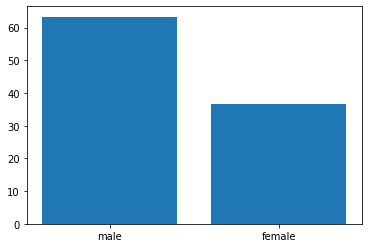

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

# distribution of gender in US, cited group

125270
male  0.6214337032010857  female  0.37856629679891435


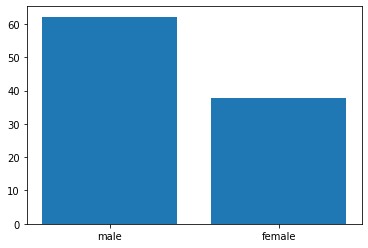

In [0]:
us = total[total['country_name'] == 'United States']
us = us[us['news_cnt'] > 0]
us = us.drop_duplicates()
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

857124
male  0.6352196414987796  female  0.36478035850122037


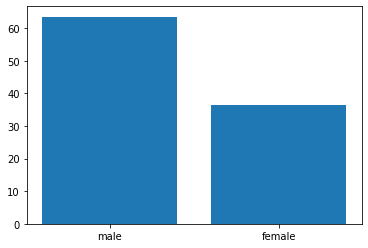

In [0]:
us = total[total['country_name'] == 'United States']
us = us[us['news_cnt'] == 0]
us = us.drop_duplicates()
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

# percent of cited female stratified by year

In [0]:
us = total[total['country_name'] == 'United States']
print(us['year'].unique())

y_19 = us[us['year'] <= 2019]

y_20 = us[us['year'] >= 2020]


cited_19 = y_19[y_19['news_cnt'] > 0]
f_19 = len(cited_19[cited_19['cor_gender'] == 'female']) + len(cited_19[cited_19['cor_gender'] == 'F']) + len(cited_19[cited_19['cor_gender'] == 'f'])

cited_20 = y_20[y_20['news_cnt'] > 0]
f_20 = len(cited_20[cited_20['cor_gender'] == 'female']) + len(cited_20[cited_20['cor_gender'] == 'F']) + len(cited_20[cited_20['cor_gender'] == 'f'])

print("percent of female in cited group in year 2018-2019 ", f_19/len(cited_19))
print("percent of female in cited group in year 2020-2022 ", f_20/len(cited_20))

[2021 2020 2018 2019 2022]
percent of female in cited group in year 2018-2019  0.36287797643569253
percent of female in cited group in year 2020-2022  0.3884935220666823


# us only, percent of female correnponding author based on field classification

domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [38.001016555329656, 34.627558556657526, 21.594985535197686, 22.541589358155917, 27.168949771689498, 52.2609561752988, 46.980519480519476, 29.503572771718687, 42.33576642335766, 30.22007135539934, 53.58249734931898, 35.410753090655774, 36.464270255840056, 56.18046313548044, 62.4006937884255, 38.0705253138739, 19.745464666143764, 32.73708558211257, 20.099797286761266, 19.126060837227044]


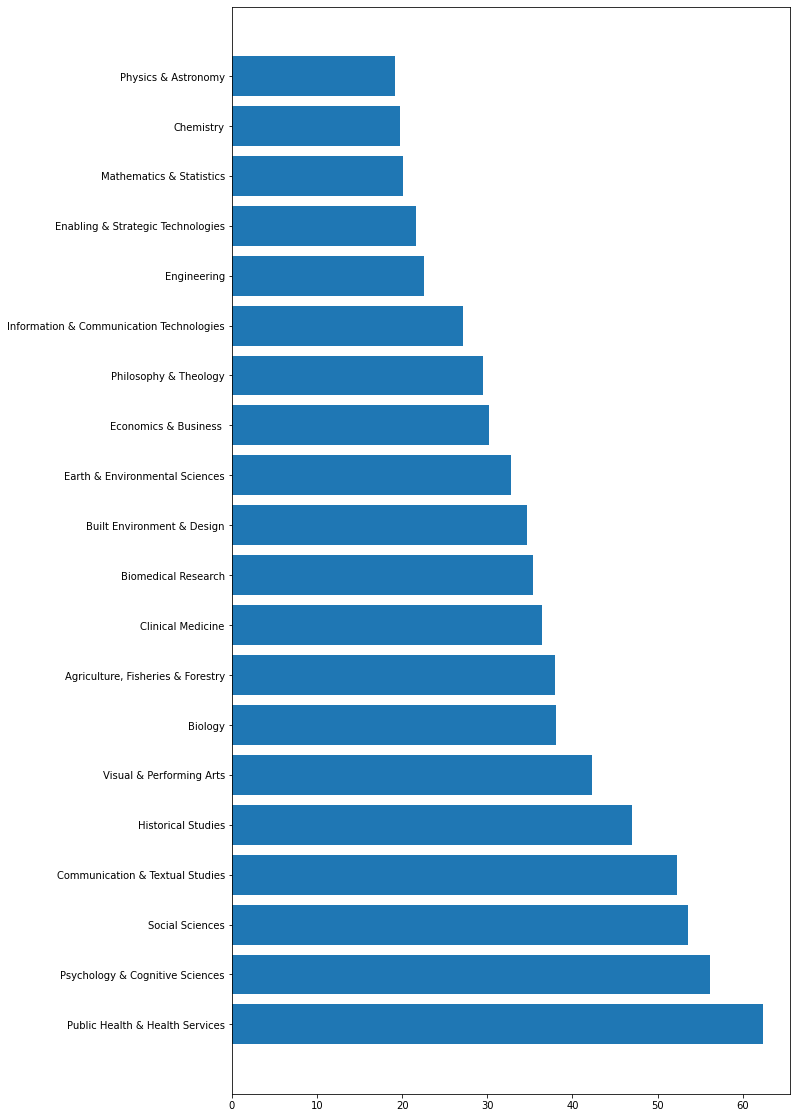

In [0]:
us = total[total['country_name'] == 'United States']
domain = us['Field_English'].unique()
female = []

for i in domain:
  tc = us[us['Field_English'] == i]
  #tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 20))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female'] = female

samp = samp.sort_values(by = ['female'], ascending=False)

plt.barh(samp['domain'], samp['female'])

plt.show()

# us only, percent of female correnponding author in the cited group based on field classification

domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [42.14186369958276, 36.187845303867405, 21.223229789697086, 24.167137210615472, 29.99349381912817, 51.92307692307693, 39.34426229508197, 35.84905660377358, 33.33333333333333, 33.856502242152466, 48.2389289392379, 33.24754174090939, 37.09867504731974, 54.659466991813275, 57.569277376815464, 37.794502617801044, 18.602885345482157, 33.626475352927564, 25.179856115107913, 19.28682977615825]


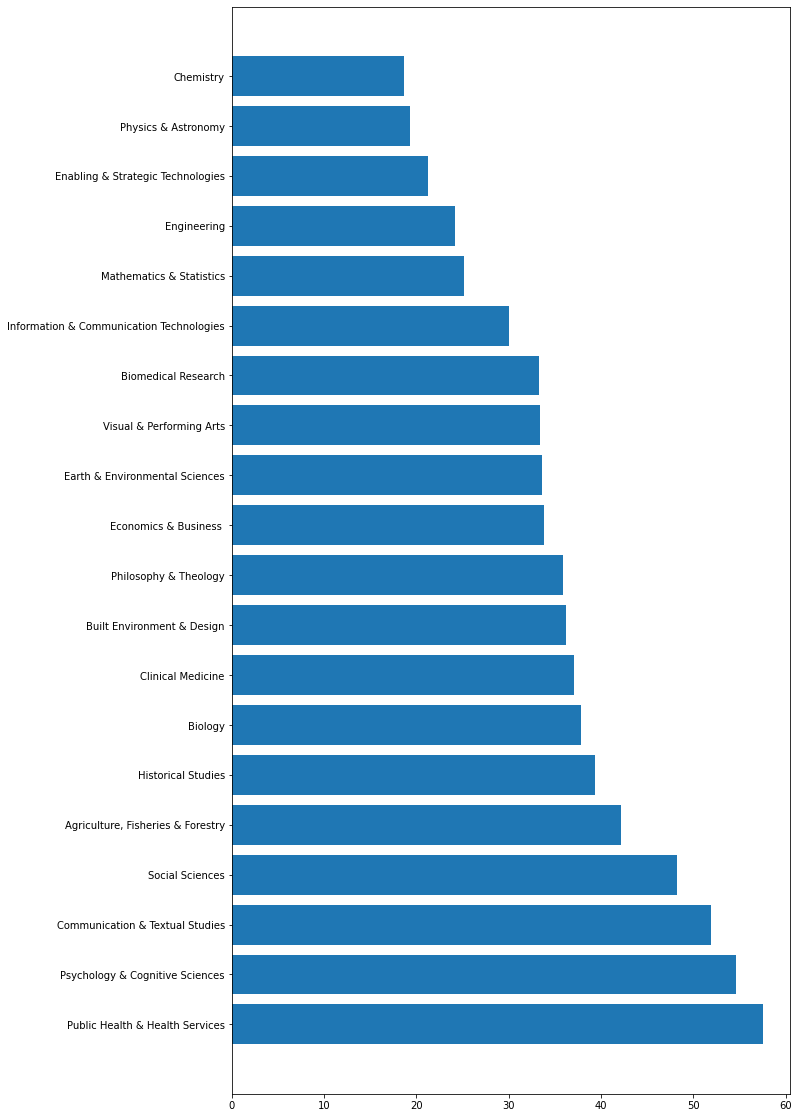

In [0]:
us = total[total['country_name'] == 'United States']
domain = us['Field_English'].unique()
female = []

for i in domain:
  tc = us[us['Field_English'] == i]
  tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 20))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female'] = female

samp = samp.sort_values(by = ['female'], ascending=False)

plt.barh(samp['domain'], samp['female'])

plt.show()

# read saved file and conduct CEM matching

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv")
print(total.dtypes)

print("len of total ", len(total))
total2 = total.dropna(subset=['srcid','year','num_au','subfield_article','cor_gender']) #replace TopicId with subfield_article
total2 = total2.drop_duplicates()


print("after dropping null and duplicates ",len(total2))

total2 = total2[total2['country_name'] == 'United States']
print("len of united states after dropping null ", len(total2))


total2['TopicId'] = total2['TopicId'].astype(str)
total2['srcid'] = total2['srcid'].astype(str)

new_yr = []
coarse_team = []
treatment = []


for ind in total2.index:
  '''if total2['year'][ind] == 2018 or total2['year'][ind] == 2019:
    new_yr.append('1')
  elif total2['year'][ind] == 2020 or total2['year'][ind] == 2021 or total2['year'][ind] == 2022:
    new_yr.append('2')'''

    
  if total2['year'][ind] == 2018:
    new_yr.append('1')
  elif total2['year'][ind] == 2019:
    new_yr.append('2')
  elif total2['year'][ind] == 2020:
    new_yr.append('3')
  elif total2['year'][ind] == 2021:
    new_yr.append('4')
  elif total2['year'][ind] == 2022:
    new_yr.append('5')
  

  
  if total2['num_au'][ind] == 1:
    coarse_team.append('1')
  elif total2['num_au'][ind] == 2:
    coarse_team.append('2')
  elif total2['num_au'][ind] == 3:
    coarse_team.append('3')
  elif total2['num_au'][ind] >= 4 and total2['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif total2['num_au'][ind] >= 6 and total2['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif total2['num_au'][ind] > 9:
    coarse_team.append('6')

  if total2['news_cnt'][ind] > 0:
    treatment.append('1')
  elif total2['news_cnt'][ind] == 0:
    treatment.append('0')

  


total2['year_cat'] = new_yr
total2['team_size'] = coarse_team
total2['treatment'] = treatment

print(total2.dtypes)

print(len(total2))




from collections import defaultdict


def match_data(data,treatment,control_var):

    
    ##get unique control tuples
    con_data = data[control_var] #control_var is a list of control variables, other than treatment,doi and gender
    un_con = con_data.drop_duplicates()
    
    ##create map of strata for unique control tuples
    mydict = defaultdict(list)
    cnt = 1
    '''for i, tup in enumerate(un_con.iterrows()):
        _, x_row = tup
        #print(x_row)
        mydict[tuple(x_row)] = cnt
        cnt += 1'''
    
    #print(mydict)
    new_data = data[control_var]
    strata = []
    
    for i, tup in enumerate(new_data.iterrows()):
        _, x_row = tup
        if tuple(x_row) in mydict:
            strata.append(mydict[tuple(x_row)])
        else:
            mydict[tuple(x_row)] = cnt
            cnt += 1
            strata.append(mydict[tuple(x_row)])
    data['strata'] = strata
    display("done with step 1","\n")
    
    
    
    value_counts = data["strata"].value_counts()

# Create a list of the values that have only one instance
    single_instances = value_counts[value_counts == 1].index

# Filter the DataFrame to only include rows where the "dog" value is not in the list of single_instances
    data = data[~data["strata"].isin(single_instances)]
    
    
    data["st_tr"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '1']))

    data["st_con"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '0']))
    
    data = data.loc[(data["st_tr"] != 0) & (data["st_con"] != 0)]
    
    st_tr = dict(zip(data['strata'], data['st_tr']))
    st_con = dict(zip(data['strata'], data['st_con']))

    display("done with step 2","\n")
    
    new = data.copy()
    
    mt = new[new[treatment] == '1']
    mc = new[new[treatment] == '0']

    new['weight'] = new['strata'].apply(lambda x: (len(mc)*st_tr[x]) / (len(mt)*st_con[x]))
    #new['weight'] = new[treatment].apply(lambda x: 1.00 if x == '1')
    row_index = new[new[treatment] == '1'].index

    # Replace all the values in the age column where the row index is in row_index with 1
    new.loc[row_index, "weight"] = 1.00
    
    
    
    
    '''weight = []
    for ind in new.index:
        s = new['strata'][ind]
        
        if new[treatment][ind] == '1':
            weight.append(1)
        else:
            ns = new[new['strata'] == s]
            mts = ns[ns[treatment] == '1']
            mcs = ns[ns[treatment] == '0']
                
            #t = new[new['strata'] != -1]
                
            
                
            weight.append((len(mc)*len(mts))/(len(mt)*len(mcs)))
    new['weight'] = weight'''
    return new
new = match_data(data = total2,treatment="treatment",control_var=['srcid','openaccess_status','year_cat','team_size','subfield_article']) #'TopicId'
#new = match_data(data = total2,treatment="treatment",control_var=['srcid','year_cat','team_size','TopicId'])


t = new[new['treatment'] == '1']
print(len(t))
c = new[new['treatment'] == '0']
print(len(c))

ft = t[t['cor_gender'] == 'female']
ft1 = t[t['cor_gender'] == 'f']
ft2 = t[t['cor_gender'] == 'F']


fc = c[c['cor_gender'] == 'female']
fc1 = c[c['cor_gender'] == 'f']
fc2 = c[c['cor_gender'] == 'F']



print((len(ft)+len(ft1)+len(ft2))/len(t)," ", (len(fc)+len(fc1)+len(fc2))/len(c)) ##0.02 more in treatment group


Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
dtype: object
len of total  982421
after dropping null and duplicates  982394
len of united states after dropping null  982394
Domain_English        object
Field_English         object
SubField_English      object
srcid                 object
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId               object
Au1

# year wise analysis

In [0]:
n1 = new[new['year'] <= 2019]
n2 = new[new['year'] >= 2020]

t = n1[n1['treatment'] == '1']
c = n1[n1['treatment'] == '0']

t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])
print(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))


t = n2[n2['treatment'] == '1']
c = n2[n2['treatment'] == '0']

t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])
print(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))


0.030095733601409658
0.019451370852858526


# assign quantile

In [0]:
q1 = total['SJR'].quantile(0.25)
q2 = total['SJR'].quantile(0.50)
q3 = total['SJR'].quantile(0.75)

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q


# insert new quantile

In [0]:
q1 = 0.1213
q2 = 0.2454
q3 = 0.58594

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q


# overall regression analysis

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a

tmp = domain(new) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+team_size+q",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  92790
length of control  310707

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.fram

# quantile based regression analysis

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a

#tmp = domain(new[new['q'] == 0]) #insig, female more likely//
#tmp = domain(new[new['q'] == 1]) #insig, male more likely//
#tmp = domain(new[new['q'] == 2]) #sig, male more likely //for new quantile: insig, female more likely
tmp = domain(new[new['q'] == 3]) #sig, female more likely//for new quantile: insig, female more likely

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2'''

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+team_size+Field_English",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  90301
length of control  299609
<command-1172027>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1172027>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1172027>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

# regression analysis, domain wise

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a


#ds = new[new['team_size'] == '1']

#ds = new[new['Domain_English'] == 'Applied Sciences'] #gender   est -8.575e-02, p val = 0.00685 **

#ds = new[new['Domain_English'] == 'Arts & Humanities'] #gender est = -8.110e-03

#ds = new[new['Domain_English'] == 'Economic & Social Sciences'] #gender est = -5.628e-03

#ds = new[new['Domain_English'] == 'Health Sciences'] #gender est = 9.324e-03

#ds = new[new['Domain_English'] == 'Natural Sciences'] #gender est -3.790e-02

'''
controlling for subfield_article : no one gave significance

'''

tmp = domain(ds) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  11977
length of control  46291
<command-1172033>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1172033>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1172033>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

# US CEM, field wise percent of female in control and treatment group

Agriculture, Fisheries & Forestry   0.12247538956026928  treatment length  1363  control length  7881
Built Environment & Design   -0.049943511628812956  treatment length  193  control length  739
Enabling & Strategic Technologies   -0.003577702704864919  treatment length  3757  control length  14171
Engineering   0.07062453143604762  treatment length  944  control length  4737
Information & Communication Technologies   0.01985895383550395  treatment length  797  control length  1988
Communication & Textual Studies   0.03714017554173483  treatment length  513  control length  1468
Historical Studies   -0.15254678541372776  treatment length  331  control length  1007
Philosophy & Theology   0.12489806320081552  treatment length  109  control length  1193
Visual & Performing Arts   -0.6938775510204082  treatment length  7  control length  15
Economics & Business    0.22945138801489198  treatment length  1863  control length  7211
Social Sciences   -0.08337842189310611  treatment length  

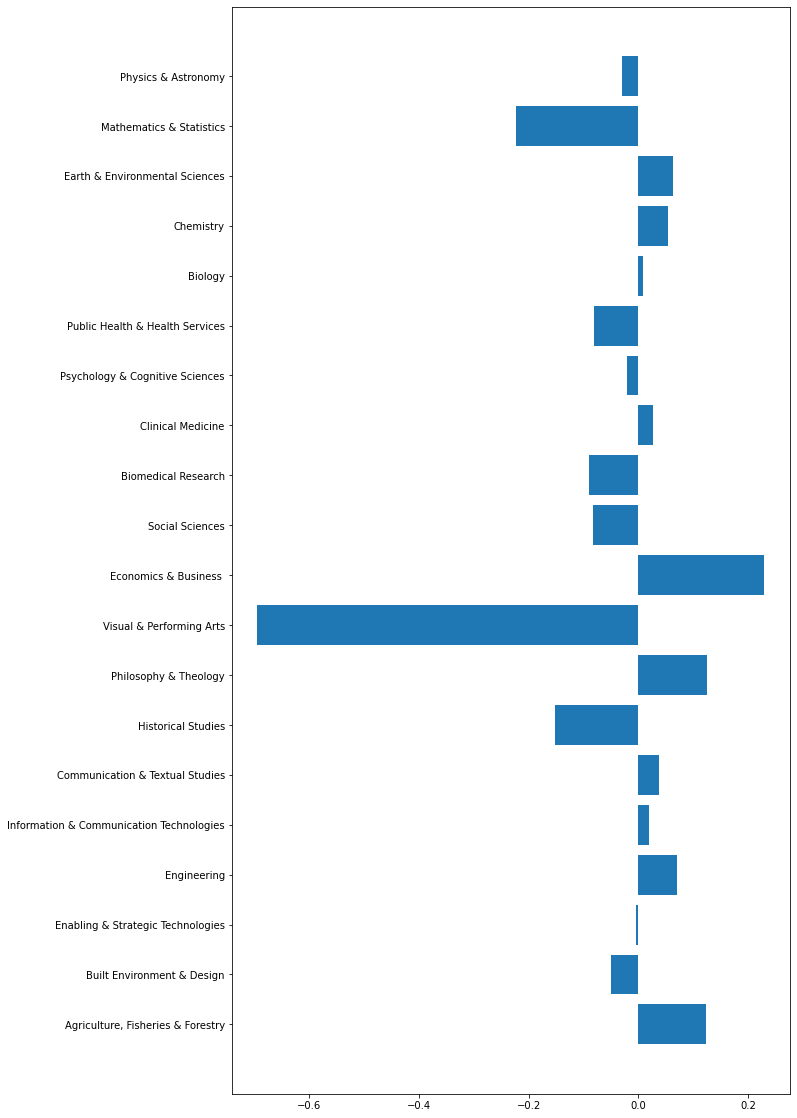

In [0]:
import matplotlib.pyplot as plt 
domain = new['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(10, 20))

for i in domain:
  tc = new[new['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
  c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
plt.barh(domain, diff)

# US CEM, subfield_article level analysis

In [0]:
import matplotlib.pyplot as plt 
domain = new['subfield_article'].unique()

for i in domain:
  tc = new[new['subfield_article'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
  c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  #diff.append(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
  if len(t) == 0 or len(c) == 0 or c_female == 0:
    print(i," division by 0 for treatment")
    continue
  if len(c) == 0:
    print(i," division by 0 for control")
    continue
  if c_female == 0:
    print(i," division by 0 for c-female")
    continue
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c))," treatment size ",len(t)," control size ",len(c))
#plt.barh(domain, diff)

agronomy & agriculture   0.18192759679229717  treatment size  314  control size  1748
dairy & animal science   0.06107692307692323  treatment size  120  control size  1254
fisheries   0.12697676473186675  treatment size  196  control size  785
food science   0.39680537094194257  treatment size  238  control size  1000
forestry   0.43072978664957445  treatment size  134  control size  625
horticulture  division by 0 for treatment
veterinary sciences   0.008462044035491246  treatment size  357  control size  2455
building & construction   0.2270861833105337  treatment size  51  control size  299
design practice & management  division by 0 for treatment
urban & regional planning   -0.1714285714285714  treatment size  140  control size  435
bioinformatics   -0.08068343616516375  treatment size  343  control size  1043
biotechnology   0.5233494363929148  treatment size  153  control size  374
energy   0.020653269525893768  treatment size  1118  control size  4569
materials   0.0529755717255

In [0]:
def subfield_art(i, new):
  a = new[new['subfield_article'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  '''if len(c) <= 5 and len(t) <= 5:
    return -1'''

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a


for i in range(130,len(dom)):
  tmp =subfield_art(dom[i], new)
  
  print("subfield &&&&&&&&&&&&&& ",dom[i])
  with localconverter(ro.default_converter + pandas2ri.converter):
    tst_df = ro.conversion.py2rpy(tmp)
  model = stats.glm("outcome ~ gender+con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
  print(base.summary(model).rx2('coefficients'))

#print(tmp.tail(10))

3303
length of treatment  607
length of control  2696
<command-1171716>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1171716>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1171716>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')


cnt = 16
dom = new['subfield_article'].unique()

#tmp =subfield_art(dom[cnt], new)
tmp = subfield_art('education', new)
  

#print("subfield &&&&&&&&&&&&&& ",dom[cnt])
with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)
model = stats.glm("outcome ~ gender+con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))
print(tmp.head(5))

6289
length of treatment  1180
length of control  5109
<command-1171716>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1171716>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1171716>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

# US CEM, field wise percent of female in control and treatment group

Agriculture, Fisheries & Forestry   0.12247538956026928
Built Environment & Design   -0.049943511628812956
Enabling & Strategic Technologies   -0.003577702704864919
Engineering   0.07062453143604762
Information & Communication Technologies   0.01985895383550395
Communication & Textual Studies   0.03714017554173483
Historical Studies   -0.15254678541372776
Philosophy & Theology   0.12489806320081552
Visual & Performing Arts   -0.6938775510204082
Economics & Business    0.22945138801489198
Social Sciences   -0.08337842189310611
Biomedical Research   -0.08919679645785861
Clinical Medicine   0.027428562989964784
Psychology & Cognitive Sciences   -0.020308487431787068
Public Health & Health Services   -0.08099110112555398
Biology   0.00876157408776929
Chemistry   0.05337895369594052
Earth & Environmental Sciences   0.06219071602708107
Mathematics & Statistics   -0.22247023809523805
Physics & Astronomy   -0.02904684574173975
Out[10]: <BarContainer object of 20 artists>

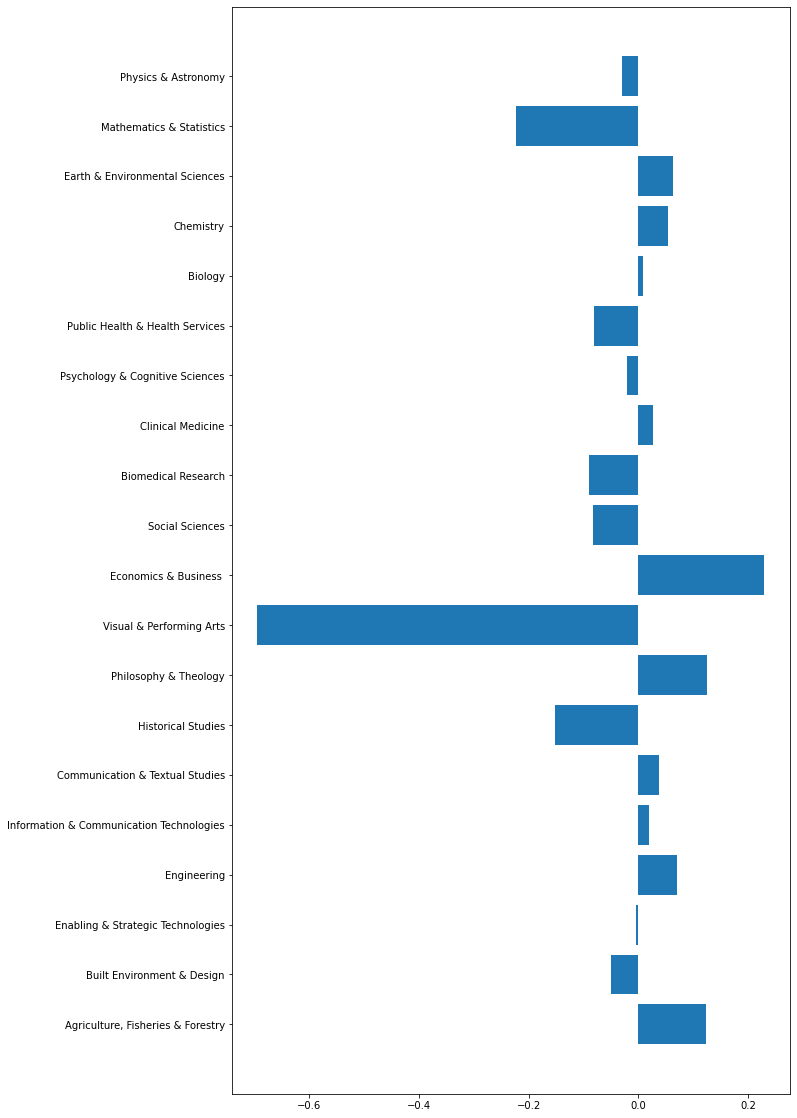

In [0]:
import matplotlib.pyplot as plt 
domain = new['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(10, 20))

for i in domain:
  tc = new[new['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
  c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
plt.barh(domain, diff)
#print(domain)
#print(diff)

# regression analysis on jorunal level

In [0]:
def domain2(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a
  


#tmp = domain2("Physics & Astronomy",new) #opposite dir  
#tmp = domain2("Mathematics & Statistics",new)    
#tmp = domain2("Earth & Environmental Sciences",new)   
#tmp = domain2("Chemistry",new)  
#tmp = domain2("Biology",new)  
#tmp = domain2("Public Health & Health Services",new)  # gender est = 0.098326, p value = 0.000164 ***
#tmp = domain2("Psychology & Cognitive Sciences",new)   #opposite dir #gender est -0.0931023, p value = 0.0137 * 
#tmp = domain2("Clinical Medicine",new) #gender est = -8.259e-03
#tmp = domain2("Biomedical Research",new)  #gender est = 2.179e-02
#tmp = domain2("Social Sciences",new) #gender est = 0.0983857, p value = 0.0209 * 
tmp = domain2("Economics & Business ",new) #gender est = -0.1947931, p value = 0.000633 ***//gender      -0.1947931  0.0570038  -3.417 0.000633 ***
#tmp = domain2("Visual & Performing Arts",new) ##too small sample size #-0.6938

#tmp = domain2("Philosophy & Theology",new) #opposite dir #gender est = 0.0664431
#tmp = domain2("Historical Studies",new) #gender est = 0.2223849
#tmp = domain2("Communication & Textual Studies",new)  #gender est = -0.185483
#tmp = domain2("Information & Communication Technologies",new)  #gender est = -0.1678595

#tmp = domain2("Engineering",new)  #gender est = -0.1218632
#tmp = domain2("Enabling & Strategic Technologies",new)   #opposite dir #gender est = -6.081e-02
#tmp = domain2("Built Environment & Design",new) #gender est = 0.2988715
#tmp = domain2("Agriculture, Fisheries & Forestry",new) #gender est = -0.127417, p value = 0.0489 *

print(tmp.tail(10))

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

9074
length of treatment  1863
length of control  7211
<command-1170752>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1170752>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1170752>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

# regression analysis on jorunal level, controlling for covid

In [0]:
def domain22(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []
  cov = []

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  a['covid'] = cov
  #a['oa'] = oa

  return a
  


#tmp = domain22("Physics & Astronomy",new) #est = -9.912e-03, p val =  0.8576
#tmp = domain22("Mathematics & Statistics",new)   #est = 0.53577, p val =  0.0647
#tmp = domain22("Earth & Environmental Sciences",new)  #est = -0.0693341, p val insig
#tmp = domain22("Chemistry",new)  
#tmp = domain22("Biology",new)  
#tmp = domain22("Public Health & Health Services",new)  # gender est = 0.0981079, p value = 0.000167 ***
#tmp = domain22("Psychology & Cognitive Sciences",new)   #opposite dir #gender est -0.0927153, p value = 0.0139 * 
#tmp = domain22("Clinical Medicine",new) #gender est = -8.240e-03, p val = 0.475
#tmp = domain22("Biomedical Research",new)  #gender est = 2.176e-02 , p val =  0.34852
#tmp = domain22("Social Sciences",new) #gender est = 0.0983578, p value = 0.021 * 
#tmp = domain22("Economics & Business ",new) #gender est = -0.1943790, p value = 0.000641 ***
#tmp = domain22("Visual & Performing Arts",new) ##too small sample size #-0.6938

#tmp = domain22("Philosophy & Theology",new) #opposite dir #gender est = 0.0659342  , p val = 0.789
#tmp = domain22("Historical Studies",new) #gender est = 0.2205235 , p val = 0.0879
#tmp = domain22("Communication & Textual Studies",new)  #gender est = -0.184911, p val = 0.0692
#tmp = domain22("Information & Communication Technologies",new)  #gender est = -0.1675375, p val = 0.0624

#tmp = domain22("Engineering",new)  #gender est = -1.219e-01, p val = 0.160
#tmp = domain22("Enabling & Strategic Technologies",new)   #opposite dir #gender est = -0.0607278, p val = 0.19
#tmp = domain22("Built Environment & Design",new) #gender est = 0.2971121, p val = 0.08805
tmp = domain22("Agriculture, Fisheries & Forestry",new) #gender est = -0.1274586, p val = 0.0489 *

print(tmp.tail(10))

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size+covid",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

9244
length of treatment  1363
length of control  7881
<command-1177138>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1177138>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1177138>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

# journal level regression, testing control

In [0]:
def domain2(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))
  print("unique subfield articles ",a['subfield_article'].nunique())

  ss = a['subfield_article'].unique()

  d1, d2,d3,d4,d5,d6,d7,d8,d9,d10 = [],[],[],[],[],[],[],[],[],[]

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []


  for ind in a.index:
    if a['subfield_article'][ind] == ss[0]:
      d1.append(1)
    else:
      d1.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[1]:
      d2.append(1)
    else:
      d2.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[2]:
      d3.append(1)
    else:
      d3.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[3]:
      d4.append(1)
    else:
      d4.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[4]:
      d5.append(1)
    else:
      d5.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[5]:
      d6.append(1)
    else:
      d6.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[6]:
      d7.append(1)
    else:
      d7.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[7]:
      d8.append(1)
    else:
      d8.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[8]:
      d9.append(1)
    else:
      d9.append(0)

  for ind in a.index:
    if a['subfield_article'][ind] == ss[9]:
      d10.append(1)
    else:
      d10.append(0)

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  a['d1'] = d1
  a['d2'] = d2 
  a['d3'] = d3
  a['d4'] = d4
  a['d5'] = d5 
  a['d6'] = d6
  a['d7'] = d7
  a['d8'] = d8 
  a['d9'] = d9
  a['d10'] = d10
  #a['oa'] = oa

  return a
  


#tmp = domain2("Physics & Astronomy",new) #opposite dir  
#tmp = domain2("Mathematics & Statistics",new)    
#tmp = domain2("Earth & Environmental Sciences",new)   
#tmp = domain2("Chemistry",new)  
#tmp = domain2("Biology",new)  
#tmp = domain2("Public Health & Health Services",new)  # gender est = 0.098326, p value = 0.000164 ***
#tmp = domain2("Psychology & Cognitive Sciences",new)   #opposite dir #gender est -0.0931023, p value = 0.0137 * 
#tmp = domain2("Clinical Medicine",new) #gender est = -8.259e-03
#tmp = domain2("Biomedical Research",new)  #gender est = 2.179e-02
#tmp = domain2("Social Sciences",new) #gender est = 0.0983857, p value = 0.0209 * 
#tmp = domain2("Economics & Business ",new) #gender est = -0.1947931, p value = 0.000633 ***
#tmp = domain2("Visual & Performing Arts",new) ##too small sample size #-0.6938

#tmp = domain2("Philosophy & Theology",new) #opposite dir #gender est = 0.0664431
#tmp = domain2("Historical Studies",new) #gender est = 0.2223849
#tmp = domain2("Communication & Textual Studies",new)  #gender est = -0.185483
#tmp = domain2("Information & Communication Technologies",new)  #gender est = -0.1678595

#tmp = domain2("Engineering",new)  #gender est = -0.1218632
#tmp = domain2("Enabling & Strategic Technologies",new)   #opposite dir #gender est = -6.081e-02
#tmp = domain2("Built Environment & Design",new) #gender est = 0.2988715
#tmp = domain2("Agriculture, Fisheries & Forestry",new) #gender est = -0.127417, p value = 0.0489 *

tmp = domain2("Economics & Business ",new)

print(tmp.tail(10))

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+d1+d2+d3+d4+d5+d6+d7+d8+d9+d10+team_size",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

9074
unique subfield articles  10
length of treatment  1863
length of control  7211
<command-1176402>:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1176402>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1176402>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [0]:
len(tmp[tmp['con_22'] == 1])

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+con_18+con_19+con_20+con_21+t1+t2+t3+t4+t5",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))
#print(base.summary(model).rx2('confint'))
#coeffs = base.summary(model).rx2('coefficients')
#print(coeffs)
#array = pandas2ri.ri2py(coeffs)
#print(coeffs.names[1][1])
#print(array)
#pandas2ri.deactivate()


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

# trend of relative difference change

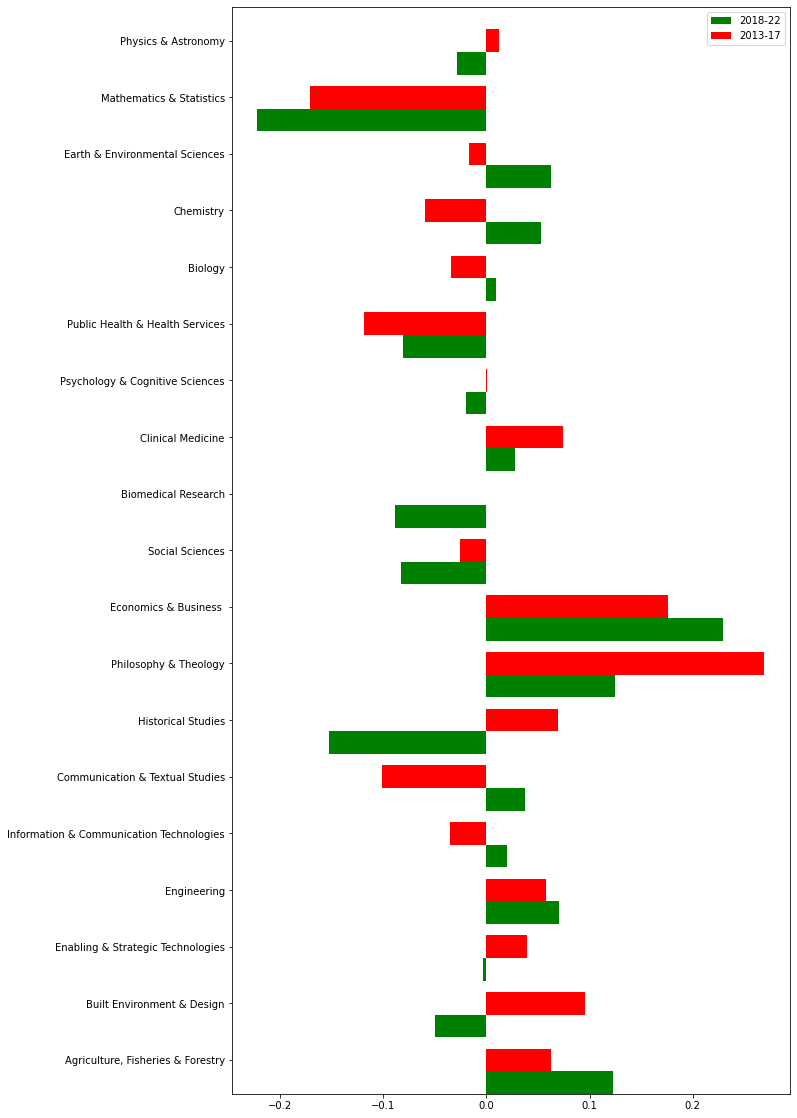

In [0]:
import matplotlib.pyplot as plt 
import numpy as np
a = new[new['Field_English'] != 'Visual & Performing Arts']
subf = a['Field_English'].unique()
#print(subf)

y1 = [0.06216, 0.09532, 0.03964, 0.05804, -0.03515, -0.10163, 0.068917, 0.26960, 0.175674, -0.026,-0.0007436,0.074424,5.772637912088413e-05 ,-0.119,-0.03440,-0.0598,-0.017,-0.1713, 0.01222]
y2 = [0.1224,-0.0499,-0.00357,0.0706,0.0198,0.0371,-0.1525,0.12489,0.2294,-0.0833,-0.08919,0.027428,-0.020308,-0.08099,0.008761,0.0533,0.0621,-0.2224,-0.029]


#fig = plt.figure(figsize =(10, 20))
ind = np.arange(len(y1))
width = 0.4

fig, ax = plt.subplots(figsize =(10, 20))
ax.barh(ind , y2, width, color='green', label='2018-22')
ax.barh(ind+ width, y1, width, color='red', label='2013-17')


ax.set(yticks=ind + width, yticklabels=subf, ylim=[2*width - 1, len(y1)])
ax.legend()

plt.show()

# regression analysis in SJR level

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(2)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)
  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender

  return a


In [0]:
q1 = new['SJR'].quantile(0.25)
q2 = new['SJR'].quantile(0.50)
q3 = new['SJR'].quantile(0.75)

tc1 = new[new['SJR'] <= q1]

tc2 = new[new['SJR'] <= q2]
tc2 = tc2[tc2['SJR'] > q1]


tc3 = new[new['SJR'] <= q3]
tc3 = tc3[tc3['SJR'] > q2]

tc4 = new[new['SJR'] > q3]

#a = domain(tc1)
#a = domain(tc2)  
#a = domain(tc3) # sig - negative
a = domain(tc4)

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

#print(tst_df)

model = stats.glm("outcome ~ gender+con_18+con_19+con_20+con_21+con_22",data=tst_df, weights = tst_df.rx2('weight'))
print(base.summary(model))

length of treatment  9400
length of control  11271
<command-1170768>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1170768>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1170768>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

# US CEM, percent of female in single author treat and control group

In [0]:
single = new[new['num_au'] == 1]

t = single[single['treatment'] == '1']
c = single[single['treatment'] == '0']

t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])

print("percent female in treatment ", t_female/len(t)," and control ",c_female/len(c))

percent female in treatment  0.3447792571829012  and control  0.35390946502057613


# US CEM, percent of female in SJR groups in treatment and control group

In [0]:
import matplotlib.pyplot as plt

q1 = new['SJR'].quantile(0.25)
q2 = new['SJR'].quantile(0.50)
q3 = new['SJR'].quantile(0.75)



tc1 = new[new['SJR'] <= q1]

tc = tc1[tc1['treatment'] == '1']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q1 treatment female ", tc_female/len(tc))

tc = tc1[tc1['treatment'] == '0']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q1 control female ", tc_female/len(tc))






tc2 = new[new['SJR'] <= q2]
tc2 = tc2[tc2['SJR'] > q1]

tc = tc2[tc2['treatment'] == '1']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q2 treatment female ", tc_female/len(tc))

tc = tc2[tc2['treatment'] == '0']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q2 control female ", tc_female/len(tc))





tc3 = new[new['SJR'] <= q3]
tc3 = tc3[tc3['SJR'] > q2]

tc = tc3[tc3['treatment'] == '1']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q3 treatment female ", tc_female/len(tc))

tc = tc3[tc3['treatment'] == '0']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q3 control female ", tc_female/len(tc))











tc4 = new[new['SJR'] > q3]

tc = tc4[tc4['treatment'] == '1']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q4 treatment female ", tc_female/len(tc))

tc = tc4[tc4['treatment'] == '0']
tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
print("q4 control female ", tc_female/len(tc))


q1 treatment female  0.4547917855105533
q1 control female  0.456391192450672
q2 treatment female  0.452062508799099
q2 control female  0.45141822570911283
q3 treatment female  0.40149379932356255
q3 control female  0.38560695344725987
q4 treatment female  0.28617021276595744
q4 control female  0.2730015082956259


# us only, percent of female in cited journal group

981901
domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [42.18097447795824, 36.187845303867405, 21.193972179289027, 24.137931034482758, 29.99349381912817, 51.861360718870344, 39.34426229508197, 35.84905660377358, 33.33333333333333, 33.856502242152466, 48.228995057660626, 33.254094030639195, 37.10585082626172, 54.659466991813275, 57.57467677218011, 37.80687397708674, 18.593155893536125, 33.63425925925926, 25.179856115107913, 19.31285788651744]


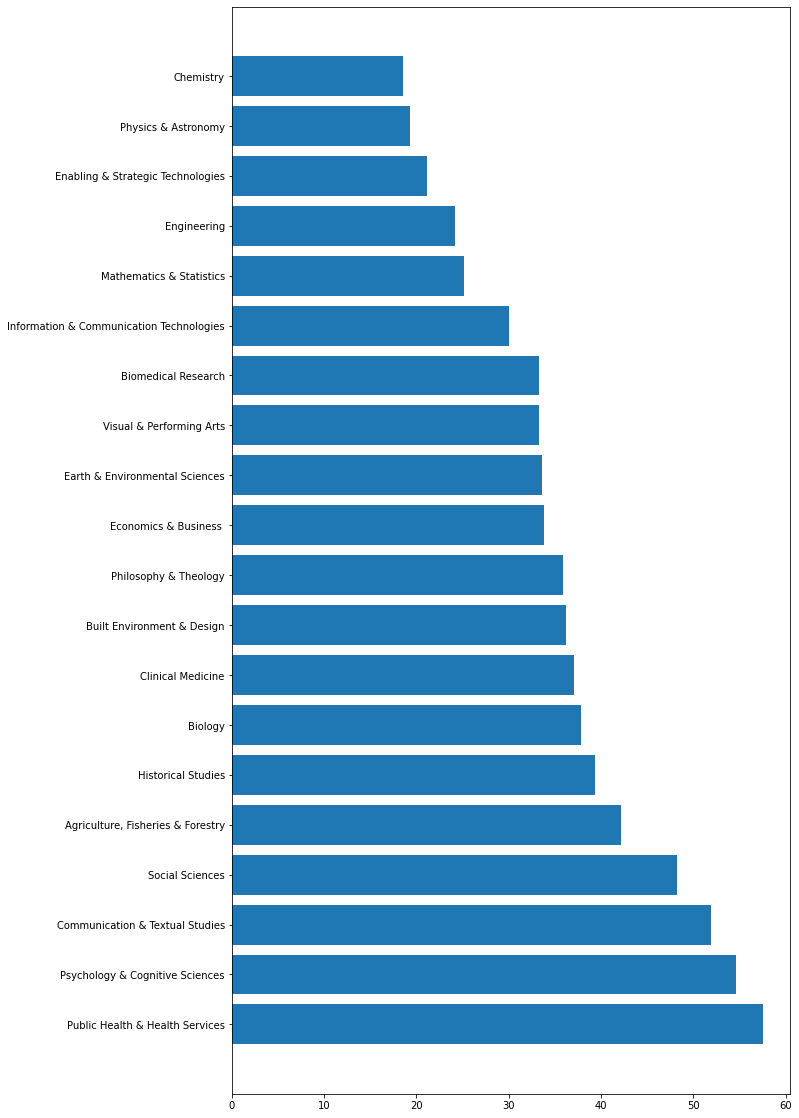

In [0]:
import matplotlib.pyplot as plt
us = total[total['country_name'] == 'United States']
print(len(us))
domain = us['Field_English'].unique()
female = []

for i in domain:
  tc = us[us['Field_English'] == i]
  tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 20))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female'] = female

samp = samp.sort_values(by = ['female'], ascending=False)

plt.barh(samp['domain'], samp['female'])

plt.show()

# affiliation analysis

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))

us_univ = us[us['org_type'] == 'univ']
print(len(us_univ))

uni_rank = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/2023_QS_World_University_Rankings.csv")
#uni_rank.printSchema()
uni_rank = uni_rank.select('Rank','institution','ar score').toPandas()

uni_mer = uni_rank.merge(us,left_on='institution', right_on='preferred_name',how = 'inner')
print(len(uni_mer))


a1 = uni_mer[uni_mer['news_cnt'] > 0]
a2 = uni_mer[uni_mer['news_cnt'] <= 0]

a1['Rank'] = a1['Rank'].astype(float)
a2['Rank'] = a2['Rank'].astype(float)

a1['ar score'] = a1['ar score'].astype(float)
a2['ar score'] = a2['ar score'].astype(float)


print(a1['Rank'].mean()," ", a1['ar score'].mean())
print(a2['Rank'].mean()," ", a2['ar score'].mean())

985810
534820
292508
301.45637084040874   50.090180832365114
380.26049563414057   42.677047667229225
<command-1169990>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['Rank'] = a1['Rank'].astype(float)
<command-1169990>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a2['Rank'] = a2['Rank'].astype(float)
<command-1169990>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

# percent of female in article level overall and cited group

In [0]:
us = total[total['country_name'] == 'United States']

field = us['subfield_article'].unique()

female = []
cited_f = []
art = []
cited = []
cf = []

for i in field:
  a = us[us['subfield_article'] == i]
  if len(a) == 0:
    continue
  art.append(i)
  f = len(a[a['cor_gender'] == 'female']) + len(a[a['cor_gender'] == 'F']) + len(a[a['cor_gender'] == 'f'])
  female.append(f/len(a))

  b = a[a['news_cnt'] > 0]
  cited.append(len(b))
  if len(b) == 0:
    cited_f.append(-1)
    cf.append(-1)
  else:
    f = len(b[b['cor_gender'] == 'female']) + len(b[b['cor_gender'] == 'F']) + len(b[b['cor_gender'] == 'f'])
    cf.append(f)
    cited_f.append(f/len(b))


samp = pd.DataFrame()
samp['article_level'] = art
samp['female%'] = female
samp['cited_female'] = cited_f
samp['cnt_cited'] = cited
samp['cnt_cited_female'] = cf
samp = samp.sort_values(by=['cited_female'], ascending=False)
print(samp.head(20))


                                   article_level   female%  cited_female  \
167                         anatomy & morphology  0.333333      1.000000   
61                                gender studies  0.793991      0.833333   
138                                  social work  0.711318      0.787234   
88                                       nursing  0.751817      0.701121   
92              developmental & child psychology  0.704751      0.690441   
66            obstetrics & reproductive medicine  0.610930      0.624365   
27                                 public health  0.653753      0.619909   
128                                   geriatrics  0.601754      0.618538   
18                           development studies  0.477745      0.612903   
141                               family studies  0.645894      0.606061   
122                                   pediatrics  0.581550      0.590278   
153                          clinical psychology  0.635586      0.577114   
123         

In [0]:
us = total[total['country_name'] == 'United States']
print(us.head(10))

    srcid                      Field_English openaccess_status  \
0   14802  Agriculture, Fisheries & Forestry                NO   
1   14802  Agriculture, Fisheries & Forestry                NO   
2   14802  Agriculture, Fisheries & Forestry                NO   
3   14802  Agriculture, Fisheries & Forestry                NO   
4   14802  Agriculture, Fisheries & Forestry                NO   
8   14802  Agriculture, Fisheries & Forestry                NO   
9   14802  Agriculture, Fisheries & Forestry                NO   
10  14802  Agriculture, Fisheries & Forestry                NO   
11  14802  Agriculture, Fisheries & Forestry                NO   
12  14802  Agriculture, Fisheries & Forestry                NO   

                              doi  news_cnt  year      issn  num_au  \
0   10.1016/j.soilbio.2018.06.026         0  2018  00380717       4   
1   10.1016/j.soilbio.2020.108111         0  2021  00380717       3   
2   10.1016/j.soilbio.2018.05.016         0  2018  00380717 

# raw count analysis

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv")
print(len(total))

samp = total[total['news_cnt'] > 0]
print(len(samp))

982421
125270


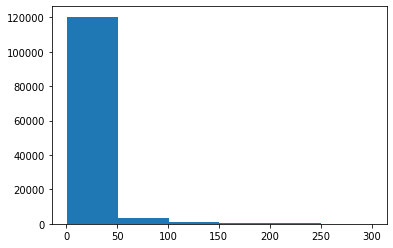

In [0]:
import matplotlib.pyplot as plt 

a = samp[samp['news_cnt'] <= 300]
plt.hist(a['news_cnt'], bins=6)
plt.show()

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv")
#print(len(total))

samp = total[total['news_cnt'] > 0]
#samp = samp[samp['year'] > 2019]

gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append(0)
  else:
    gender.append(1)
samp['gender'] = gender

'''m= samp[samp['gender'] == 1]
f= samp[samp['gender'] == 0]

print(m['news_cnt'].mean())
print(f['news_cnt'].mean())'''

coarse_team = []
for ind in samp.index:
  if samp['num_au'][ind] == 1:
      coarse_team.append('1')
  elif samp['num_au'][ind] == 2:
    coarse_team.append('2')
  elif samp['num_au'][ind] == 3:
    coarse_team.append('3')
  elif samp['num_au'][ind] >= 4 and samp['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif samp['num_au'][ind] >= 6 and samp['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif samp['num_au'][ind] > 9:
    coarse_team.append('6')

samp['team_size'] = coarse_team


q1 = 0.1213
q2 = 0.2454
q3 = 0.58594

q = []
for ind in samp.index:
  if samp['SJR'][ind] <= q1:
    q.append(0)
  elif samp['SJR'][ind] > q1 and samp['SJR'][ind] <= q2:
    q.append(1)
  elif samp['SJR'][ind] > q2 and samp['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
samp['q'] = q

<command-1177260>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp['gender'] = gender
<command-1177260>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp['team_size'] = coarse_team
<command-1177260>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp['q'

# domain wise regression analysis on raw count

In [0]:
def domain3(a):
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]

  print("len of unique subfield ", a['subfield_article'].nunique())

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
  a['covid'] = cov

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6

  a = a.drop(['srcid'], axis=1)

  return a


#ds = new[new['team_size'] == '1']

#ds = samp[samp['Domain_English'] == 'Applied Sciences'] #gender   est 0.119556, p val = < 2e-16 ***

#ds = samp[samp['Domain_English'] == 'Arts & Humanities'] #gender est = 0.301278, p val = < 2e-16 ***

#ds = samp[samp['Domain_English'] == 'Economic & Social Sciences'] #gender est = 0.198745, p val = < 2e-16 ***

#ds = samp[samp['Domain_English'] == 'Health Sciences'] #gender est = 0.089255, p val = < 2e-16 ***

ds = samp[samp['Domain_English'] == 'Natural Sciences'] #gender est 0.205960 , p val = < 2e-16 ***

'''
controlling for subfield_article : no one gave significance

'''

tmp = domain3(ds) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("news_cnt ~ gender+year+q+subfield_article+team_size+covid",
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))

len of unique subfield  33
<command-1177262>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['covid'] = cov
<command-1177262>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['t1'] = t1
<command-1177262>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['t2']

# subfield level, raw count regression analysis

In [0]:
def domain33(i,new):
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #mm,ff = [],[]

  a = new[new['Field_English'] == i]

  f = a[a['gender'] == 0]
  m = a[a['gender'] == 1]
  print("male ",m['news_cnt'].mean()," female ",f['news_cnt'].mean())

  '''for ind in a.index:
    if a['gender'][ind] == 0:
      ff.append(1)
    else:
      ff.append(0)

  for ind in a.index:
    if a['gender'][ind] == 1:
      mm.append(1)
    else:
      mm.append(0)

  a['mm'] = mm
  a['ff'] = ff'''

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
  a['covid'] = cov

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6

  #a = a.drop(['srcid'], axis=1)
  a['srcid'] = a['srcid'].astype(str)

  return a


#tmp = domain33("Physics & Astronomy",samp) #gender       0.20282    0.01119  18.129  < 2e-16 ***
#tmp = domain33("Mathematics & Statistics",samp) #gender -1.96326    0.09486 -20.697  < 2e-16 ***
#tmp = domain33("Earth & Environmental Sciences",samp)# est = 0.260946, p val = < 2e-16 ***
#tmp = domain33("Chemistry",samp)  #est = 0.11266, p val = 2.56e-08 ***
#tmp = domain33("Biology",samp)  #est = 0.170164, p val = < 2e-16 ***
#tmp = domain33("Public Health & Health Services",samp)  # gender est = 0.261062, p value = < 2e-16 ***
#tmp = domain33("Psychology & Cognitive Sciences",samp)   #gender est 0.083127, p value = < 2e-16 *** 
#tmp = domain33("Clinical Medicine",samp) #gender est = 0.035630, p val = < 2e-16 ***
#tmp = domain33("Biomedical Research",samp)  #gender est = 0.126883, p val = < 2e-16 *** 
#tmp = domain33("Social Sciences",samp) #gender est = 0.176793, p value = < 2e-16 *** 
#tmp = domain33("Economics & Business ",samp) #gender est = 0.24622, p value = < 2e-16 *** 
#tmp = domain33("Visual & Performing Arts",samp) ##too small sample size #-0.6938

tmp = domain33("Philosophy & Theology",samp) #0.51991    0.06393   8.132 4.21e-16 ***
#tmp = domain33("Historical Studies",samp) #0.18104    0.02366   7.652 1.98e-14 ***
#tmp = domain33("Communication & Textual Studies",samp)  #0.36998    0.02365  15.645  < 2e-16 ***
#tmp = domain33("Information & Communication Technologies",samp)  #gender est = 0.47805,p val = < 2e-16 ***

#tmp = domain33("Engineering",samp)  #gender  est = 0.112420, p val = 7.18e-11 ***
#tmp = domain33("Enabling & Strategic Technologies",samp) #gender est = 0.05043, p val = 4.26e-06 ***
#tmp = domain33("Built Environment & Design",samp) #gender est = 0.68668, p val = < 2e-16 ***
#tmp = domain33("Agriculture, Fisheries & Forestry",samp) #gender est = -0.02296, p val = 0.099009

print(tmp.tail(10))

'''
controlling for subfield_article : no one gave significance

'''



import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("news_cnt ~ gender+year+q+subfield_article+team_size+covid",
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))
#modsum = base.summary(model)
#rsquared = modsum.rx2('r.squared')
#print(rsquared)



male  7.5661764705882355  female  5.473684210526316
           Domain_English          Field_English      SubField_English  \
156094  Arts & Humanities  Philosophy & Theology  religions & theology   
156112  Arts & Humanities  Philosophy & Theology  religions & theology   
156118  Arts & Humanities  Philosophy & Theology  religions & theology   
156189  Arts & Humanities  Philosophy & Theology  religions & theology   
156216  Arts & Humanities  Philosophy & Theology  religions & theology   
156226  Arts & Humanities  Philosophy & Theology  religions & theology   
156249  Arts & Humanities  Philosophy & Theology  religions & theology   
156254  Arts & Humanities  Philosophy & Theology  religions & theology   
156277  Arts & Humanities  Philosophy & Theology  religions & theology   
156278  Arts & Humanities  Philosophy & Theology  religions & theology   

              srcid openaccess_status                            doi  \
156094  21100286926               YES            10.3390/rel1

# subfield level, raw count regression, with srcid as control and removing q from control variable

In [0]:
def domain_src(i,new):
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #mm,ff = [],[]

  a = new[new['Field_English'] == i]

  f = a[a['gender'] == 0]
  m = a[a['gender'] == 1]
  print("male ",m['news_cnt'].mean()," female ",f['news_cnt'].mean())

  '''for ind in a.index:
    if a['gender'][ind] == 0:
      ff.append(1)
    else:
      ff.append(0)

  for ind in a.index:
    if a['gender'][ind] == 1:
      mm.append(1)
    else:
      mm.append(0)

  a['mm'] = mm
  a['ff'] = ff'''

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
  a['covid'] = cov

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6

  #a = a.drop(['srcid'], axis=1)
  a['srcid'] = a['srcid'].astype(str)

  return a


#tmp = domain_src("Physics & Astronomy",samp) #est=  0.203508470, p val = 1.976754e-70 ***
#tmp = domain_src("Mathematics & Statistics",samp) # gender -0.12809835  0.2724980 -0.4700892 6.382913e-01
#tmp = domain_src("Earth & Environmental Sciences",samp)# gender  est = 0.192393942 , p val = 4.38596166e-144 *** 
#tmp = domain_src("Chemistry",samp)  #gender  est = 0.135779645 0.02239451, p val = 1.33542067e-09 ***
#tmp = domain_src("Biology",samp)  #gender   est = 0.086912278 0.007866053, p val = 2.21588424e-28 ***
#tmp = domain_src("Public Health & Health Services",samp)  # gender est = 1.485384e-01, p val = 4.75791957e-122
#tmp = domain_src("Psychology & Cognitive Sciences",samp)   #gender est 0.023399689, p value = 8.61303689e-03 **
tmp = domain_src("Clinical Medicine",samp) #[ 2.33996886e-02  8.90723362e-03  2.62704332e+00  8.61303689e-03], ###problem
#tmp = domain_src("Biomedical Research",samp)  #gender est = 0.031999015 , p val = 1.92728640e-09 ***
#tmp = domain_src("Social Sciences",samp) #gender est = 0.124061270, p val = 2.76391114e-26 ***
#tmp = domain_src("Economics & Business ",samp) #gender est = 0.198169490, p value = 4.04915914e-29 *** 
#tmp = domain_src("Visual & Performing Arts",samp) ##too small sample size #-0.6938

#tmp = domain_src("Philosophy & Theology",samp) #est = 0.2997462456, p val = 9.995772e-04 ***
#tmp = domain_src("Historical Studies",samp) #est = 0.094014542, p val = 4.290696e-04 ***
#tmp = domain_src("Communication & Textual Studies",samp)  #est = 0.301802635, p val =  1.85889444e-22 ***
#tmp = domain_src("Information & Communication Technologies",samp)  #gender est = 0.384523414, p val =  7.41785023e-056 ***

#tmp = domain_src("Engineering",samp)  #est = 0.156871538, p val = 7.14181667e-16 ***
#tmp = domain_src("Enabling & Strategic Technologies",samp) #gender est = 0.028555801 0.01178624, p val = 1.54010145e-02 *
#tmp = domain_src("Built Environment & Design",samp) #gender est = 0.25670881, p val = 1.706541e-06 ***
#tmp = domain_src("Agriculture, Fisheries & Forestry",samp) #gender est = -0.05634344, p val = 4.44665632e-04 ***

#print(tmp.tail(10))

'''
controlling for subfield_article : no one gave significance

'''

import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2'''

'''col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('srcid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('srcid'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("news_cnt ~ gender+year+subfield_article+team_size+covid+srcid",
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model).rx2("coefficients"))


coeffs = base.summary(model).rx2('coefficients')
#print(np.array(coeffs))

#print(np.array(coeffs)[1])


#print(coeffs)



#p_values = model.rx('summary').rx('coefficients')[0, 4] #base.summary(model).rx2('coefficients')[0, 4]
#print(p_values)
'''
print(coeffs[0])
print(coeffs[1])
print(coeffs[2])
print(coeffs[3])'''

#array = pandas2ri.ri2py(base.summary(model))
#array = ro.conversion.py2rpy(base.summary(model))

#print(coeffs.names[1][1])
#print(array[0])
#print(array.rx2("coefficients"))
#pandas2ri.deactivate()



male  9.730114120252086  female  9.81613400077012
<command-1189316>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['covid'] = cov
<command-1189316>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['t1'] = t1
<command-1189316>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [0]:
new = new.sort_values(by=['strata'])
print(new.head(10))

                          Field_English        SubField_English        srcid  \
2     Agriculture, Fisheries & Forestry  agronomy & agriculture  21100457028   
3328  Agriculture, Fisheries & Forestry  agronomy & agriculture  21100457028   
5969  Agriculture, Fisheries & Forestry  agronomy & agriculture  21100457028   
2403  Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
1465  Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
191   Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
385   Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
4001  Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
2852  Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   
5053  Agriculture, Fisheries & Forestry  agronomy & agriculture        37206   

     openaccess_status                     doi  news_cnt  year      issn  \
2                  YES  10.1126/sciadv.aat1

In [0]:
print(len(new[new['treatment'] == '1']), " ",len(new[new['treatment'] == '0']))

37730   71039


In [0]:
(3*71039)/(4*37730)

Out[117]: 1.412119003445534

In [0]:
total[total['issn'] == "00368075"]

,Field_English,SubField_English,srcid,openaccess_status,doi,news_cnt,year,issn,num_au,cor_gender,TopicId,Au1_gender,country_name,SJR,subfield_article,preferred_name,org_type
1,"Agriculture, Fisheries & Forestry",agronomy & agriculture,23571,NO,10.1126/science.aaz5670,14,2019,00368075,1,male,29960,male,United States,13.110,agronomy & agriculture,University of Colorado Boulder,univ
2257,"Agriculture, Fisheries & Forestry",agronomy & agriculture,23571,NO,10.1126/science.aao0457,0,2018,00368075,5,female,1359,female,United States,13.251,agronomy & agriculture,Lawrence Berkeley National Laboratory,resi
5116,"Agriculture, Fisheries & Forestry",agronomy & agriculture,23571,NO,10.1126/science.aaz5619,2,2019,00368075,1,female,4515,female,United States,13.110,agronomy & agriculture,United States Department of Energy,govt
7419,"Agriculture, Fisheries & Forestry",dairy & animal science,23571,NO,10.1126/science.abi9023,0,2021,00368075,6,male,15401,female,United States,14.589,dairy & animal science,American Association for the Advancement of Sc...,ngov
9966,"Agriculture, Fisheries & Forestry",fisheries,23571,NO,10.1126/science.aat6713,7,2018,00368075,5,male,12171,male,United States,13.251,fisheries,University of Washington,univ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981444,Physics & Astronomy,optics,23571,NO,10.1126/science.aba8996,11,2020,00368075,12,M,543,unknown,United States,12.556,optics,University of Pennsylvania,univ
981708,Physics & Astronomy,optics,23571,NO,10.1126/science.abc2666,25,2021,00368075,7,M,1042,unknown,United States,14.589,optics,Yale University,univ
981710,Physics & Astronomy,optics,23571,NO,10.1126/science.aas9437,13,2018,00368075,10,M,6243,male,United States,13.251,optics,Yale University,univ
981759,Physics & Astronomy,optics,23571,NO,10.1126/science.abg2533,44,2021,00368075,10,F,1288,unknown,United States,14.589,optics,Cornell University College of Engineering,coll


In [0]:
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
print(len(smc))
smc = smc.drop_duplicates()
print(len(smc))

34985
175


In [0]:
print(smc)

                           Field_English              SubField_English
0      Agriculture, Fisheries & Forestry        Agronomy & Agriculture
261    Agriculture, Fisheries & Forestry        Dairy & Animal Science
418    Agriculture, Fisheries & Forestry                     Fisheries
529    Agriculture, Fisheries & Forestry                  Food Science
685    Agriculture, Fisheries & Forestry                      Forestry
...                                  ...                           ...
34420                Physics & Astronomy               General Physics
34510                Physics & Astronomy          Mathematical Physics
34544                Physics & Astronomy    Nuclear & Particle Physics
34678                Physics & Astronomy                        Optics
34764       article-level classification  article-level classification

[175 rows x 2 columns]


In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a

tmp = domain(new) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

length of treatment  92741
length of control  310499

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.fram

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []
  yr = []
  for ind in a.index:
    if a['year'][ind] == 2018:
      yr.append(0)
    elif a['year'][ind] == 2019:
      yr.append(1)
    elif a['year'][ind] == 2020:
      yr.append(2)
    elif a['year'][ind] == 2021:
      yr.append(3)
    elif a['year'][ind] == 2022:
      yr.append(4)


  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  a['yr'] = yr
  #a['oa'] = oa

  return a

tmp = domain(new[new['Field_English'] == 'Social Sciences']) 
#tmp = domain(new)

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+team_size+year", 
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22
print(base.summary(model))

length of treatment  3070
length of control  11070
<command-1171760>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-1171760>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-1171760>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [0]:
t = new[new['treatment'] == '1']
f1 = t[t['cor_gender'] == 'female']
f2 = t[t['cor_gender'] == 'F']
f3 = t[t['cor_gender'] == 'f']
f1 = f1.append(f2, ignore_index=True)
f1 = f1.append(f3, ignore_index=True)
print(f1['news_cnt'].mean())

m1 = t[t['cor_gender'] == 'male']
m2 = t[t['cor_gender'] == 'M']
m3 = t[t['cor_gender'] == 'm']
m1 = m1.append(m2, ignore_index=True)
m1 = m1.append(m3, ignore_index=True)
print(m1['news_cnt'].mean())

9.339888280893753
9.793300058923434
